# 稳健增长资产配置研究

长期投资应该以股票为主，因为各种历史数据表明股票是长期回报最好的大类资产。但是股票的波动太高，很难长期坚持持有，因此资产配置的目的是降低整个投资组合的最大回撤，同时不牺牲太多的收益。多类资产之所以能够降低组合的波动率和最大回撤，主要是因为各类资产的价格走势不完全相关，彼此对冲了波动。和股票相关度低但是又有长期正收益的资产是理想的配置的标的。

资产配置的三大要素是收益、风险和相关度。我们将在考察各类资产上述指标的基础上，构建一个风险调整后预期收益最大化的投资组合，并且将风险控制在个人风险承受能力之内。

研究大纲：
+ 主要资产类别的收益率分析
	- 股票
	- 长期国债
	- 黄金
	- REITS
	- 大宗商品
	- 比特币
+ 各类资产比较分析
	- 各类资产风险收益比对比分析
	- 各类资产相关度分析

In [1]:
# import packages
import seaborn as sns
from matplotlib import pyplot as plt
import yfinance as yf
import datetime as dt
import pandas as pd
import pyfolio as pf
from scipy import stats

/opt/anaconda3/envs/skydog/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


## 全局参数

In [2]:
#重要参数
ticker_list=['QQQ','SPY','SPLV','MCHI','GLD','TLT','GSG','VNQ','BTC-USD','SHY','KWEB','2822.HK']
display=['QQQ','SPLV','SPY','2822.HK','MCHI','KWEB'] # to simply chart for easier reading
focus='QQQ' # to simply chart for correlation
start_date=dt.date(2000,1,1)
end_date=dt.date.today()
recent=5*365 # period in days for stats of recent data
horizon=10*365 # period in days for time horizon in charts

# ticker_list=['0700.HK','BABA','FB','1810.HK','TME']
# display=ticker_list
# focus=['0700.HK']

## 主要资产类别的日收益率数据分析

### 各类资产的定义

本文通过各大类资产代表性的指数ETF（这也是我们最终构建组合的标的）来比较其风险与收益：
+ 股票：
	- QQQ：QQQ不能代表整个股市，但却是最终我最想投资的股指ETF，因为我认为最好的公司都在纳斯达克100指数
	- SPY：标普500是比较典型的代表美股的指数
	- MCHI: 用于代表中概股，因为同时投资中美是未来一个长期策略
	- 2822.HK: A50指数ETF，用于代表中国大盘股
	- FXI: 美股大盘因子
	- SPLV：美股低波动因子
+ 比特币：Yahoo Finance的比特币美元价格 BTC-USD
+ 黄金: GLD
+ 大宗商品: GSG
+ 美国长期国债: TLT
+ REITS: VNQ

In [3]:
#get price data 


df_price=pd.DataFrame()

for ticker in ticker_list:
    data=yf.download(ticker,start_date,end_date,auto_adjust=True)
    price=data.Close
    df_price[ticker]=price



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
#daily return stat
df_return=df_price.pct_change()
df_stat=pd.DataFrame()
for ticker in ticker_list:
	df_stat[ticker]=df_return[ticker].describe()
    
df_stat=df_stat.T

df_stat['mean_annualized']=df_stat['mean']*250
df_stat['std_annualized']=df_stat['std']*250**0.5
df_stat


,count,mean,std,min,25%,50%,75%,max,mean_annualized,std_annualized
QQQ,5525.0,0.000441,0.017292,-0.119788,-0.006349,0.001149,0.007891,0.168421,0.110233,0.273408
SPY,5525.0,0.000360,0.012374,-0.109424,-0.004572,0.000708,0.005927,0.145198,0.090086,0.195647
SPLV,2672.0,0.000511,0.009574,-0.123890,-0.003190,0.000741,0.004769,0.098094,0.127844,0.151372
MCHI,2696.0,0.000264,0.015387,-0.097666,-0.008212,0.000227,0.009203,0.093783,0.066075,0.243291
GLD,4298.0,0.000372,0.011347,-0.087808,-0.005132,0.000555,0.006138,0.112905,0.092914,0.179410
TLT,4880.0,0.000297,0.008749,-0.066683,-0.004704,0.000568,0.005353,0.075196,0.074217,0.138338
GSG,3878.0,-0.000171,0.014893,-0.120811,-0.007673,0.000477,0.007734,0.076196,-0.042690,0.235475
VNQ,4334.0,0.000543,0.019109,-0.195137,-0.006193,0.000940,0.007631,0.170065,0.135872,0.302136
BTC-USD,1825.0,0.003637,0.046201,-0.371695,-0.015134,0.002161,0.022369,0.252472,0.909213,0.730508
SHY,4880.0,0.000077,0.000857,-0.006567,-0.000354,0.000000,0.000473,0.007095,0.019362,0.013552


In [5]:
df_return_recent=df_return[end_date-dt.timedelta(days=recent):]
df_stat_recent=df_return_recent.describe().T
df_stat_recent['mean_annualized']=df_stat_recent['mean']*250
df_stat_recent['std_annualized']=df_stat_recent['std']*250**0.5
df_stat_recent

,count,mean,std,min,25%,50%,75%,max,mean_annualized,std_annualized
QQQ,1257.0,0.001082,0.014038,-0.119788,-0.003967,0.001676,0.007731,0.084706,0.270460,0.221960
SPY,1257.0,0.000726,0.011860,-0.109424,-0.002933,0.000930,0.005718,0.090603,0.181389,0.187523
SPLV,1257.0,0.000522,0.011202,-0.123890,-0.002838,0.000856,0.004585,0.098094,0.130414,0.177115
MCHI,1257.0,0.000460,0.015363,-0.097666,-0.007054,0.000626,0.009584,0.072685,0.115113,0.242915
GLD,1257.0,0.000378,0.008440,-0.053694,-0.003967,0.000661,0.004809,0.048530,0.094509,0.133443
TLT,1257.0,0.000316,0.008814,-0.066683,-0.004582,0.000348,0.005066,0.075196,0.079078,0.139369
GSG,1257.0,0.000142,0.013459,-0.120811,-0.005956,0.001283,0.007086,0.067774,0.035483,0.212804
VNQ,1257.0,0.000504,0.014062,-0.177277,-0.004819,0.001061,0.006726,0.089966,0.126048,0.222343
BTC-USD,1257.0,0.004527,0.049536,-0.371695,-0.016674,0.002525,0.026273,0.252472,1.131698,0.783240
SHY,1257.0,0.000061,0.000620,-0.004384,-0.000239,0.000000,0.000351,0.005453,0.015160,0.009809


### 单一资产的日收益率统计分析

Text(0.5, 1.0, 'All Historical Daily Return Histgram - 5525 days')

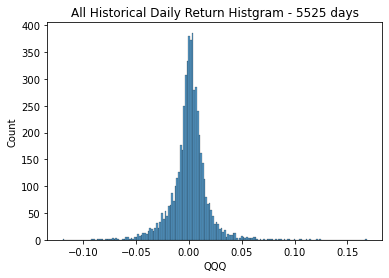

In [6]:
asset='QQQ'
sns.histplot(data=df_return[asset])
plt.title('All Historical Daily Return Histgram - %i days'%(df_stat.loc[asset]['count']))


Text(0.5, 1.0, 'Recent Historical Daily Return Histgram - 1257 days')

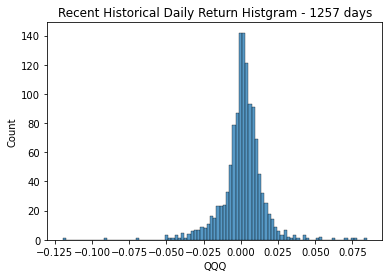

In [7]:

sns.histplot(data=df_return_recent[asset])
plt.title('Recent Historical Daily Return Histgram - %i days'%(df_stat_recent.loc[asset]['count']))

Start date,2000-01-03
End date,2021-12-15
Total months,263
,Backtest
Annual return,7.627%
Cumulative returns,401.014%
Annual volatility,27.45%
Sharpe ratio,0.40
Calmar ratio,0.09
Stability,0.73
Max drawdown,-82.964%


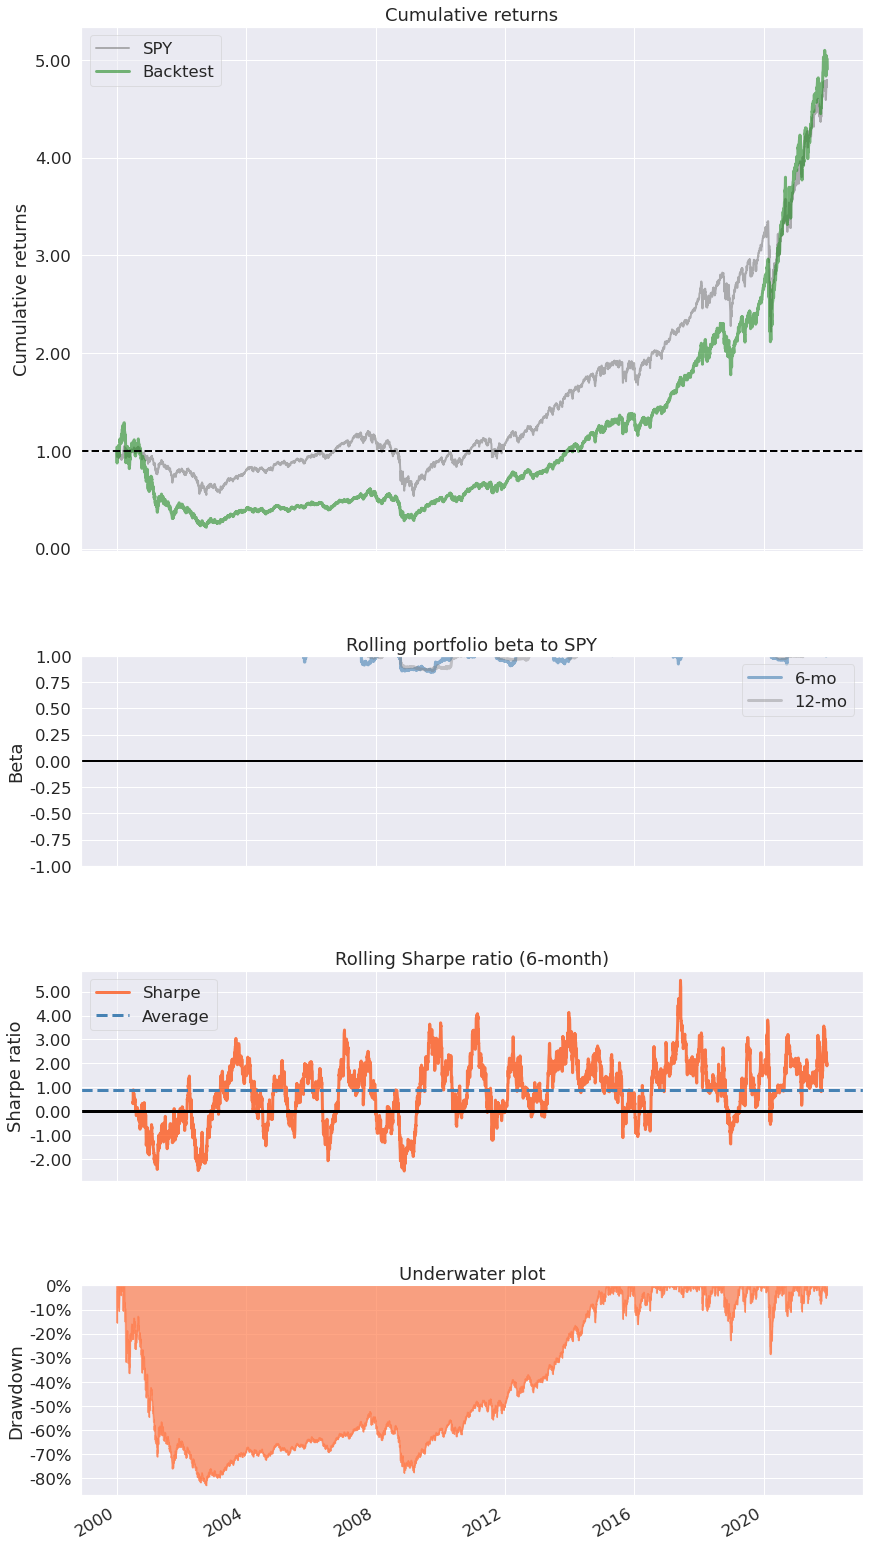

In [8]:
pf.create_simple_tear_sheet(df_return[asset].dropna(),
                            benchmark_rets=df_return['SPY'].dropna())

## 各类资产历史收益率比较分析


### 滚动收益率对比

首先我们观察的滚动的1年收益率。

Text(0.5, 1.0, 'Historical Rolling 1 Year Return')

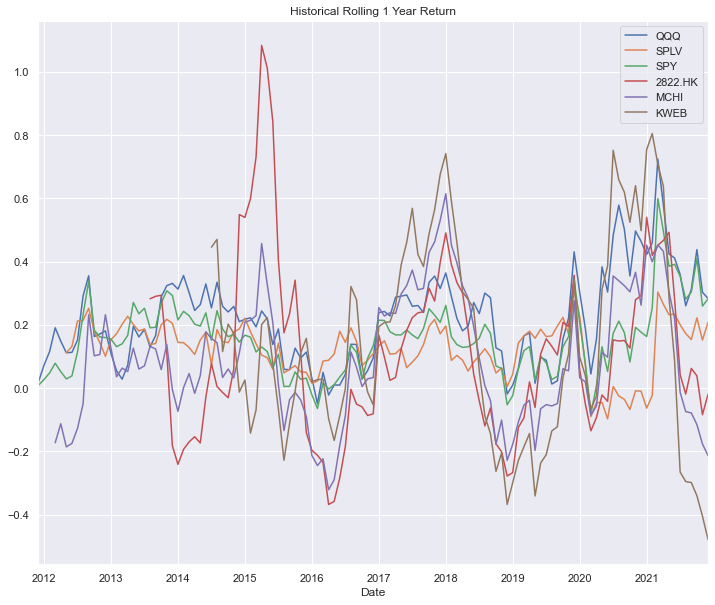

In [9]:
resample='M'
sns.set()
df_return_roll_actual=df_price/df_price.shift(250)-1
df_return_roll_actual.resample(resample).last().loc[(end_date-dt.timedelta(days=horizon)):][display].plot(figsize=(12,10))
plt.title('Historical Rolling 1 Year Return')

下面是滚动的3年收益率。

Text(0.5, 1.0, 'Historical Rolling 3 Year Return - Anualized')

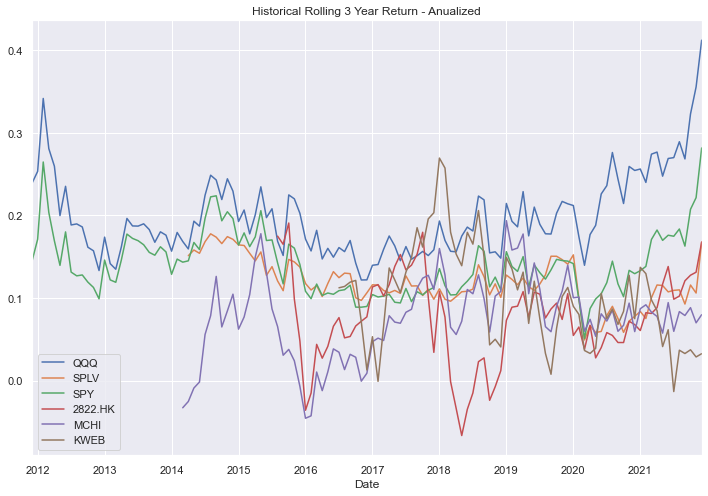

In [10]:
resample='M'
df_return_roll_actual=(df_price/df_price.shift(250*3))**(1/3)-1
df_return_roll_actual.resample(resample).last().loc[(end_date-dt.timedelta(days=horizon)):][display].plot(figsize=(12,8))
plt.title('Historical Rolling 3 Year Return - Anualized')

Text(0.5, 1.0, 'Cummulative Return Comparision')

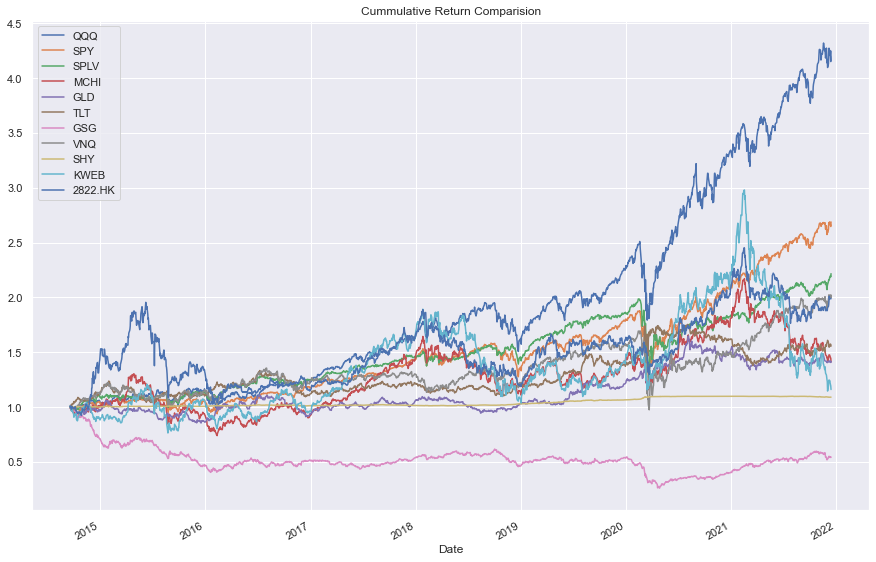

In [11]:
#累计收益率比较
# https://matplotlib.org/stable/tutorials/introductory/customizing.html  rcParams
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10) 
(df_return.dropna().drop(columns='BTC-USD')+1).cumprod().plot() #draw cum return trend lines, remove BTC-USD
plt.title('Cummulative Return Comparision')

### 预期收益率比较

下面，通过资产的日收益的均值来观测其预期收益率的变化。

下面是各类资产的全部历史数据的日收益率均值反应的预期年化收益率。

Text(0.5, 1.0, 'Expected Return based on all historical data')

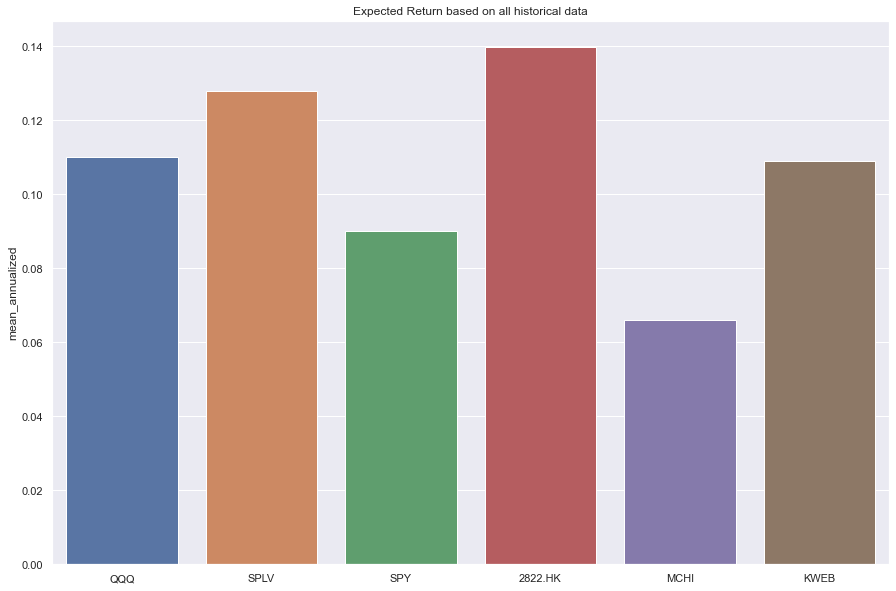

In [12]:
sns.barplot(data=df_stat.loc[display],x=df_stat.loc[display].index,y='mean_annualized')
plt.title('Expected Return based on all historical data')

Text(0.5, 1.0, 'Expected Return based on recent 5 years')

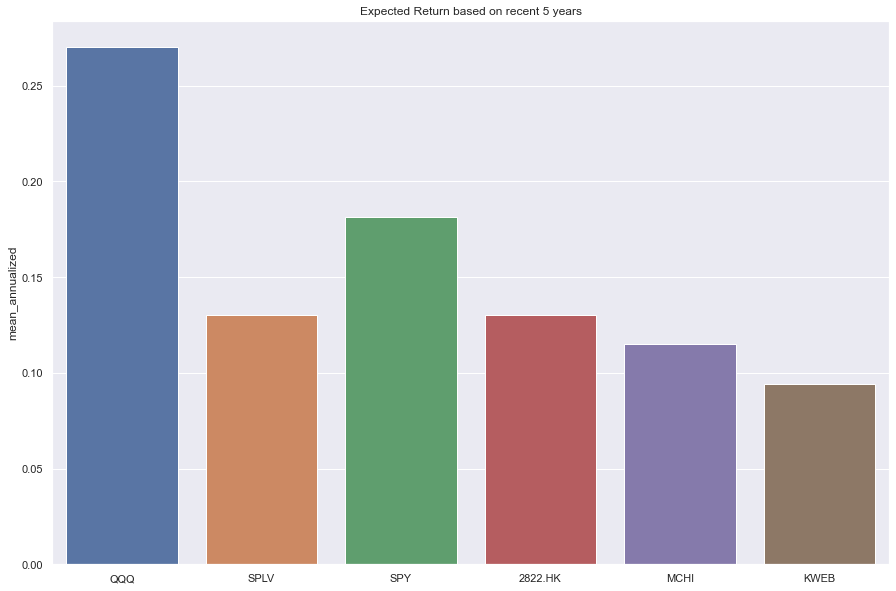

In [13]:
sns.barplot(data=df_stat_recent.loc[display],x=df_stat_recent.loc[display].index,y='mean_annualized')
plt.title('Expected Return based on recent %i years'%(recent/365))

### 各类资产收益/风险比分析

下面是各类资产所有历史日收益率数据反应出的风险和收益情况对比。

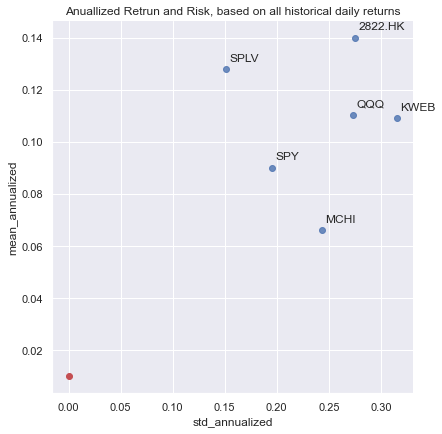

In [14]:
sns.set()
riskfree=0.01
sns.lmplot(x='std_annualized',y='mean_annualized',data=df_stat.loc[display],ci=None,height=6,fit_reg=False)

plt.title('Anuallized Retrun and Risk, based on all historical daily returns')
#plot text
for i in range(df_stat.loc[display].shape[0]):
    plt.text(x=df_stat.loc[display]['std_annualized'][i]+0.003,y=df_stat.loc[display]['mean_annualized'][i]+0.003,s=df_stat.loc[display].index[i]
          )
plt.plot(0,riskfree,'ro')


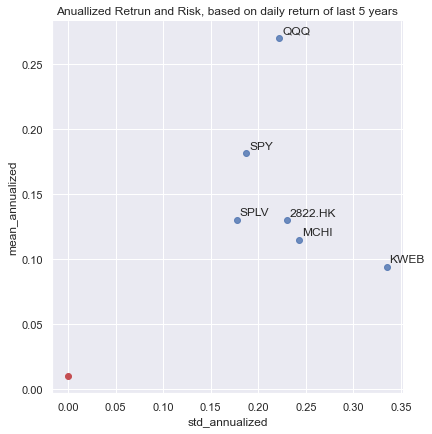

In [15]:
sns.set()
riskfree=0.01
sns.lmplot(x='std_annualized',y='mean_annualized',data=df_stat_recent.loc[display],ci=None,height=6,fit_reg=False)

plt.title('Anuallized Retrun and Risk, based on daily return of last %i years'%(recent/365))
#plot text
for i in range(df_stat_recent.loc[display].shape[0]):
    plt.text(x=df_stat_recent.loc[display]['std_annualized'][i]+0.003,y=df_stat_recent.loc[display]['mean_annualized'][i]+0.003,s=df_stat_recent.loc[display].index[i]
          )
plt.plot(0,riskfree,'ro')


### 各类资产相关度分析

In [16]:

def cal_rolling_cov(s1,s2,period):
    start_date=s1.index[0]
    cov=dict()
    while start_date<s1.index.max()-dt.timedelta(days=period):
        end_date=start_date+dt.timedelta(days=period)
        a1=s1[start_date:end_date]
        a2=s2[start_date:end_date]
        cov[end_date]=stats.pearsonr(a1, a2)[0]
        start_date=start_date+dt.timedelta(days=1)
    cov=pd.Series(cov)
    cov.name=s1.name+'-'+s2.name

    return pd.Series(cov)


In [17]:
#90 days correlation
df_return=df_return.dropna()
period=90
focus='QQQ'

df_cov=pd.DataFrame()

for ticker1 in ticker_list:
    for ticker2 in ticker_list:
        if ticker2+'_'+ticker1 in df_cov.columns:
            df_cov[ticker1+'_'+ticker2]=df_cov[ticker2+'_'+ticker1]
        else:
            df_cov[ticker1+'_'+ticker2]=cal_rolling_cov(df_return[ticker1],df_return[ticker2],period)

/var/folders/xh/qf91klxs2h968ktlg16n4pyc0000gn/T/ipykernel_9306/623413793.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cov[ticker1+'_'+ticker2]=df_cov[ticker2+'_'+ticker1]
/var/folders/xh/qf91klxs2h968ktlg16n4pyc0000gn/T/ipykernel_9306/623413793.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cov[ticker1+'_'+ticker2]=cal_rolling_cov(df_return[ticker1],df_return[ticker2],period)


In [18]:

pd.options.display.float_format = '{:,.2f}'.format
df_cov_90d=pd.DataFrame(index=ticker_list)
for ticker1 in ticker_list:
    for ticker2 in ticker_list:
        df_cov_90d.loc[ticker1,ticker2]=df_cov[ticker1+'_'+ticker2].iloc[-1]

df_cov_90d


,QQQ,SPY,SPLV,MCHI,GLD,TLT,GSG,VNQ,BTC-USD,SHY,KWEB,2822.HK
QQQ,1.00,0.91,0.48,0.36,-0.01,-0.20,0.35,0.49,0.32,-0.06,0.40,0.15
SPY,0.91,1.00,0.72,0.35,-0.08,-0.32,0.58,0.66,0.33,-0.15,0.38,0.25
SPLV,0.48,0.72,1.00,0.09,0.03,-0.23,0.49,0.74,0.15,-0.04,0.10,0.15
MCHI,0.36,0.35,0.09,1.00,0.11,-0.41,0.28,0.15,0.23,-0.39,0.93,0.56
GLD,-0.01,-0.08,0.03,0.11,1.00,0.31,0.03,0.08,0.01,0.25,0.13,-0.13
TLT,-0.20,-0.32,-0.23,-0.41,0.31,1.00,-0.47,-0.13,-0.15,0.40,-0.42,-0.36
GSG,0.35,0.58,0.49,0.28,0.03,-0.47,1.00,0.54,0.27,-0.25,0.32,0.26
VNQ,0.49,0.66,0.74,0.15,0.08,-0.13,0.54,1.00,0.23,-0.15,0.18,0.00
BTC-USD,0.32,0.33,0.15,0.23,0.01,-0.15,0.27,0.23,1.00,-0.01,0.23,0.08
SHY,-0.06,-0.15,-0.04,-0.39,0.25,0.40,-0.25,-0.15,-0.01,1.00,-0.39,-0.22


Text(0.5, 1.0, '90 Days Correlation of QQQ and other assets')

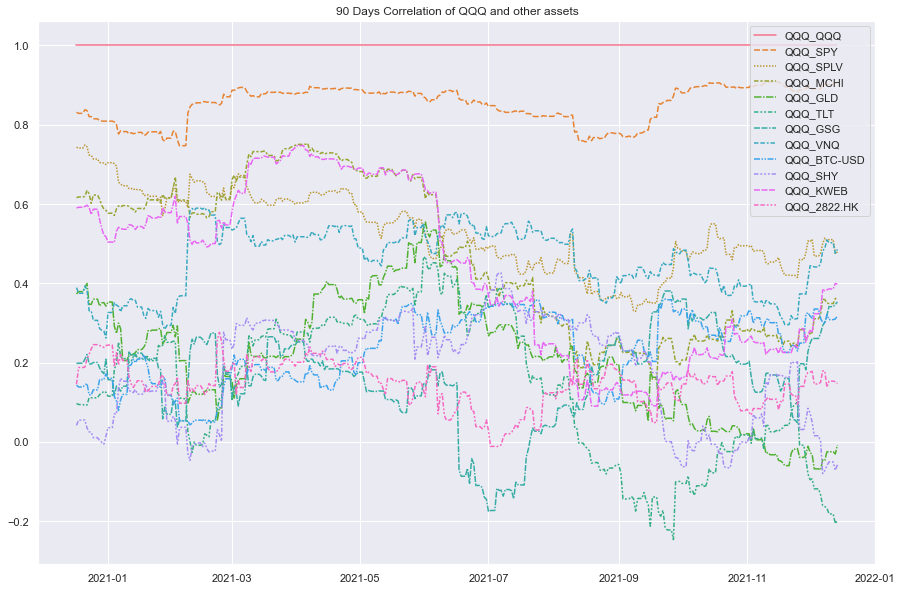

In [19]:

col=[]
for ticker in ticker_list:
    col.append(focus+"_"+ticker)
df_cov_filtered=df_cov[col]
plot=sns.lineplot(data=df_cov_filtered.loc[dt.date.today()-dt.timedelta(days=365):])
plt.title('%i Days Correlation of %s and other assets'%(period,focus))

In [20]:
#365 days correlation
period=365
#focus='QQQ'
df_return=df_price.resample('1M').last().pct_change().dropna()
df_cov=pd.DataFrame()

for ticker1 in ticker_list:
    for ticker2 in ticker_list:
        df_cov[ticker1+'_'+ticker2]=cal_rolling_cov(df_return[ticker1],df_return[ticker2],period)


/var/folders/xh/qf91klxs2h968ktlg16n4pyc0000gn/T/ipykernel_9306/3077296912.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cov[ticker1+'_'+ticker2]=cal_rolling_cov(df_return[ticker1],df_return[ticker2],period)


In [21]:

df_cov_365d=pd.DataFrame(index=ticker_list)
for ticker1 in ticker_list:
    for ticker2 in ticker_list:
        df_cov_365d.loc[ticker1,ticker2]=df_cov[ticker1+'_'+ticker2].iloc[-1]

df_cov_365d

,QQQ,SPY,SPLV,MCHI,GLD,TLT,GSG,VNQ,BTC-USD,SHY,KWEB,2822.HK
QQQ,1.00,0.83,0.64,0.20,0.17,0.59,-0.00,0.76,0.40,-0.26,0.11,-0.28
SPY,0.83,1.00,0.86,0.10,0.28,0.21,0.19,0.96,0.53,-0.20,-0.00,-0.20
SPLV,0.64,0.86,1.00,-0.19,0.44,0.18,-0.08,0.86,0.35,0.04,-0.35,-0.36
MCHI,0.20,0.10,-0.19,1.00,-0.06,-0.20,0.43,0.06,0.12,-0.32,0.95,0.68
GLD,0.17,0.28,0.44,-0.06,1.00,0.24,-0.07,0.24,-0.10,0.43,-0.22,0.30
TLT,0.59,0.21,0.18,-0.20,0.24,1.00,-0.24,0.22,-0.28,-0.06,-0.28,-0.31
GSG,-0.00,0.19,-0.08,0.43,-0.07,-0.24,1.00,0.29,0.29,-0.08,0.38,0.37
VNQ,0.76,0.96,0.86,0.06,0.24,0.22,0.29,1.00,0.45,-0.05,-0.06,-0.27
BTC-USD,0.40,0.53,0.35,0.12,-0.10,-0.28,0.29,0.45,1.00,-0.22,0.16,-0.20
SHY,-0.26,-0.20,0.04,-0.32,0.43,-0.06,-0.08,-0.05,-0.22,1.00,-0.33,-0.18


Text(0.5, 1.0, '365 Days Correlation')

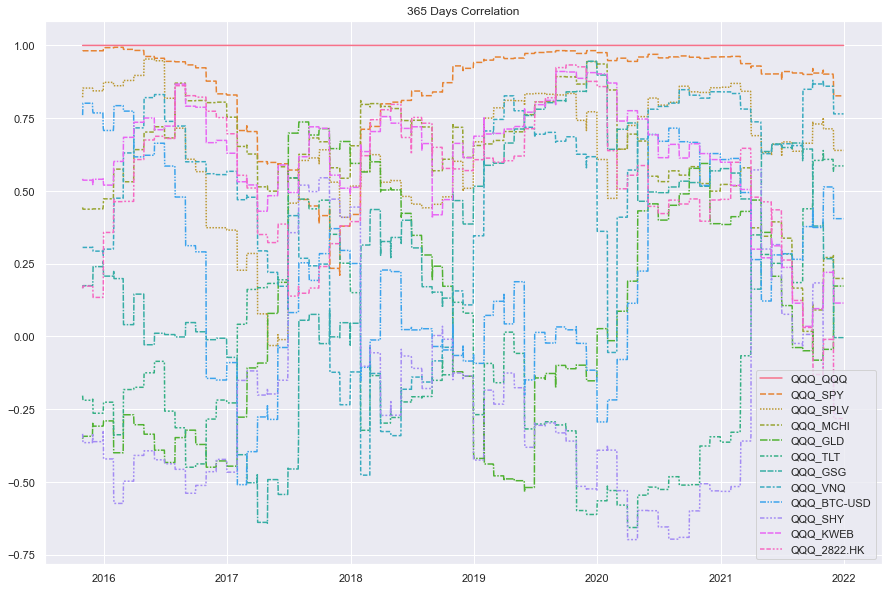

In [22]:
col=[]
for ticker in ticker_list:
    col.append(focus+"_"+ticker)
df_cov_filtered=df_cov[col]
plot=sns.lineplot(data=df_cov_filtered.loc[dt.date.today()-dt.timedelta(days=365*10):])
plt.title('%i Days Correlation'%(period))